In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

file_path = "/content/drive/MyDrive/CICD/balanced_builds_10000_chunks.json"

chunks = pd.read_json(file_path, lines=True, chunksize=10000)

for chunk in chunks:
    print(chunk.head())
    break

         repository_name  run_number  run_attempt         event     status  \
0  haraldk/TwelveMonkeys       313.0          1.0  pull_request  completed   
1    opendilab/LightZero       162.0          1.0          push  completed   
2     gagebenne/pydexcom         7.0          1.0          push  completed   
3        mgerhardy/vengi      1500.0          1.0          push  completed   
4   alirezanet/Husky.Net       127.0          1.0          push  completed   

  conclusion                created_at            run_started_at  \
0    success 2023-09-26 15:57:57+00:00 2023-09-26 15:57:57+00:00   
1    success 2023-09-15 04:00:52+00:00 2023-09-15 04:00:52+00:00   
2    success 2023-08-09 01:05:32+00:00 2023-08-09 01:05:32+00:00   
3    success 2023-09-21 05:22:21+00:00 2023-09-21 05:22:21+00:00   
4    success 2023-09-19 18:57:23+00:00 2023-09-19 18:57:23+00:00   

                 updated_at  \
0 2023-09-26 16:05:34+00:00   
1 2023-09-15 04:01:35+00:00   
2 2023-08-09 01:06:22+00:00  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the balanced JSON dataset
file_path = "/content/drive/MyDrive/CICD/balanced_builds_10000_chunks.json"
df = pd.read_json(file_path, lines=True)

# Keep only the desired columns
columns_to_use = [
    "repository_name", "workflow_path", "run_number", "run_attempt", "event",
    "status", "conclusion", "created_at", "run_started_at", "updated_at",
    "head_commit.message", "actor.login", "logs_archive", "total_logs_size", "log_insights"
]
df = df[[col for col in columns_to_use if col in df.columns]]

# Fill missing values
df = df.fillna("unknown")

# Convert datetime columns to numeric timestamps
datetime_cols = ['created_at', 'run_started_at', 'updated_at']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9  # seconds since epoch
        df[col] = df[col].fillna(0)  # replace NaT with 0

# Encode categorical features (exclude target 'conclusion')
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'conclusion']

label_encoders = {}
for col in categorical_cols:
    df[col] = df[col].astype(str)  # Ensure string
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode target
target_le = LabelEncoder()
df['conclusion'] = target_le.fit_transform(df['conclusion'])

# Split features and target
X = df.drop('conclusion', axis=1)
y = df['conclusion']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_le.classes_))


Accuracy: 0.8575

Confusion Matrix:
 [[ 367  609]
 [ 246 4778]]

Classification Report:
               precision    recall  f1-score   support

     failure       0.60      0.38      0.46       976
     success       0.89      0.95      0.92      5024

    accuracy                           0.86      6000
   macro avg       0.74      0.66      0.69      6000
weighted avg       0.84      0.86      0.84      6000



In [ ]:
import pandas as pd

# Load dataset
file_path = "/content/drive/MyDrive/CICD/balanced_builds_10000_chunks.json"
df = pd.read_json(file_path, lines=True)

# Check class distribution
class_counts = df['conclusion'].value_counts()
print("Class distribution:\n", class_counts)

# Percentage of each class
class_percent = df['conclusion'].value_counts(normalize=True) * 100
print("\nClass distribution (%):\n", class_percent)


Class distribution:
 conclusion
success    24959
failure     5041
Name: count, dtype: int64

Class distribution (%):
 conclusion
success    83.196667
failure    16.803333
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load dataset
file_path = "/content/drive/MyDrive/CICD/balanced_builds_10000_chunks.json"
df = pd.read_json(file_path, lines=True)

# Keep only desired columns
columns_to_use = [
    "repository_name", "workflow_path", "run_number", "run_attempt", "event",
    "status", "conclusion", "created_at", "run_started_at", "updated_at",
    "head_commit.message", "actor.login", "total_logs_size", "log_insights"
]
df = df[[col for col in columns_to_use if col in df.columns]]

# Fill missing values
df = df.fillna("unknown")

# Convert datetime columns to numeric
datetime_cols = ['created_at', 'run_started_at', 'updated_at']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9
        df[col] = df[col].fillna(0)

# Feature engineering from log_insights
def extract_log_features(log_insights_list):
    if isinstance(log_insights_list, list):
        total_lines = sum(d.get('total_lines', 0) for d in log_insights_list)
        error_lines = sum(d.get('lines_with_errors', 0) for d in log_insights_list)
        warning_lines = sum(d.get('lines_with_warnings', 0) for d in log_insights_list)
        return pd.Series([total_lines, error_lines, warning_lines])
    else:
        return pd.Series([0, 0, 0])

df[['log_total_lines', 'log_error_lines', 'log_warning_lines']] = df['log_insights'].apply(extract_log_features)
df = df.drop(columns=['log_insights'])

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'conclusion']

label_encoders = {}
for col in categorical_cols:
    df[col] = df[col].astype(str)
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Encode target
target_le = LabelEncoder()
df['conclusion'] = target_le.fit_transform(df['conclusion'])

# Check original class distribution
print("Original class distribution:\n", df['conclusion'].value_counts())

# Balance dataset (undersample successes)
df_success = df[df['conclusion'] == target_le.transform(['success'])[0]]
df_failure = df[df['conclusion'] == target_le.transform(['failure'])[0]]

df_success_balanced = df_success.sample(n=len(df_failure), random_state=42)
df_balanced = pd.concat([df_success_balanced, df_failure]).sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBalanced class distribution:\n", df_balanced['conclusion'].value_counts())

# Split features and target
X = df_balanced.drop('conclusion', axis=1)
y = df_balanced['conclusion']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred = rf_model.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_le.classes_))


Original class distribution:
 conclusion
1    24959
0     5041
Name: count, dtype: int64

Balanced class distribution:
 conclusion
1    5041
0    5041
Name: count, dtype: int64

Accuracy: 0.7114526524541398

Confusion Matrix:
 [[721 292]
 [290 714]]

Classification Report:
               precision    recall  f1-score   support

     failure       0.71      0.71      0.71      1013
     success       0.71      0.71      0.71      1004

    accuracy                           0.71      2017
   macro avg       0.71      0.71      0.71      2017
weighted avg       0.71      0.71      0.71      2017



/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:08:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8440504807692307

Confusion Matrix:
 [[4128  882]
 [ 675 4299]]

Classification Report:
               precision    recall  f1-score   support

     failure       0.86      0.82      0.84      5010
     success       0.83      0.86      0.85      4974

    accuracy                           0.84      9984
   macro avg       0.84      0.84      0.84      9984
weighted avg       0.84      0.84      0.84      9984



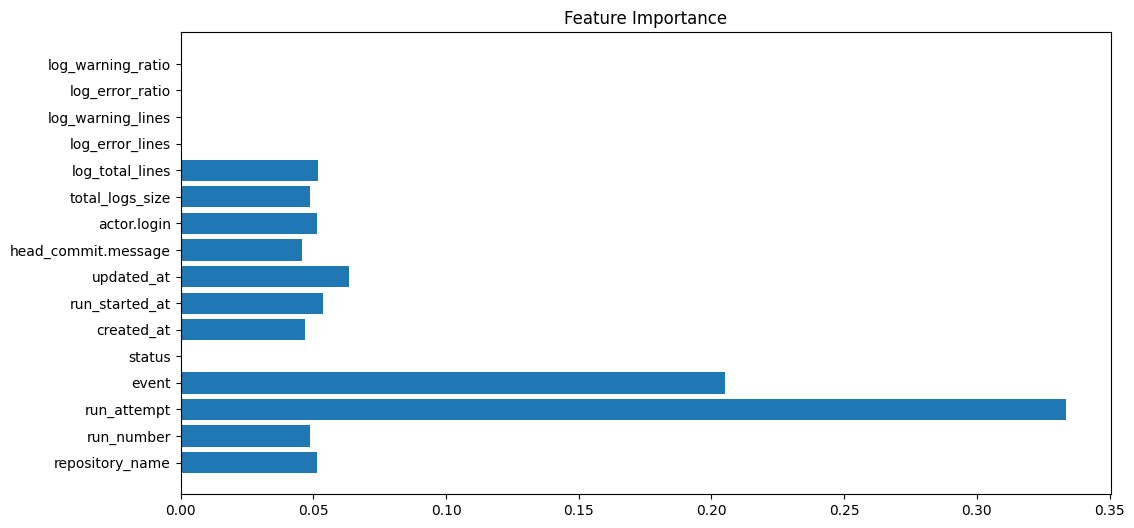

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load dataset
file_path = "/content/drive/MyDrive/CICD/balanced_builds_10000_chunks.json"
df = pd.read_json(file_path, lines=True)

# Keep only relevant columns
columns_to_use = [
    "repository_name", "workflow_path", "run_number", "run_attempt", "event",
    "status", "conclusion", "created_at", "run_started_at", "updated_at",
    "head_commit.message", "actor.login", "total_logs_size", "log_insights"
]
df = df[[col for col in columns_to_use if col in df.columns]]

# Fill missing values
df = df.fillna("unknown")

# Convert datetime columns to numeric (seconds since epoch)
datetime_cols = ['created_at', 'run_started_at', 'updated_at']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9
        df[col] = df[col].fillna(0)

# Feature engineering from logs
def extract_log_features(log_insights_list):
    if isinstance(log_insights_list, list):
        total_lines = sum(d.get('total_lines', 0) for d in log_insights_list)
        error_lines = sum(d.get('lines_with_errors', 0) for d in log_insights_list)
        warning_lines = sum(d.get('lines_with_warnings', 0) for d in log_insights_list)
        error_ratio = error_lines / total_lines if total_lines > 0 else 0
        warning_ratio = warning_lines / total_lines if total_lines > 0 else 0
        return pd.Series([total_lines, error_lines, warning_lines, error_ratio, warning_ratio])
    else:
        return pd.Series([0, 0, 0, 0, 0])

df[['log_total_lines', 'log_error_lines', 'log_warning_lines', 'log_error_ratio', 'log_warning_ratio']] = df['log_insights'].apply(extract_log_features)
df = df.drop(columns=['log_insights'])

# Encode all categorical features
X = df.drop('conclusion', axis=1)
y = df['conclusion']

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode target
target_le = LabelEncoder()
y = target_le.fit_transform(y)

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost (optional, small random search for demo)
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1],
    'gamma': [0, 1]
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=10, cv=3,
                                   scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_le.classes_))

# Feature importance
importances = best_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(12,6))
plt.barh(feature_names, importances)
plt.title("Feature Importance")
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:13:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8688902243589743

Confusion Matrix:
 [[4275  735]
 [ 574 4400]]

Classification Report:
               precision    recall  f1-score   support

     failure       0.88      0.85      0.87      5010
     success       0.86      0.88      0.87      4974

    accuracy                           0.87      9984
   macro avg       0.87      0.87      0.87      9984
weighted avg       0.87      0.87      0.87      9984



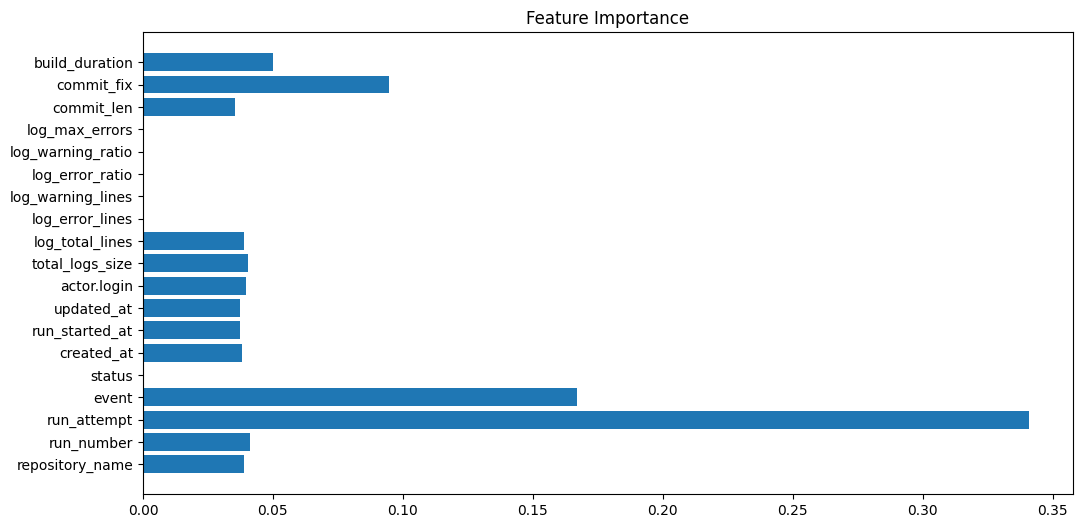

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load dataset
file_path = "/content/drive/MyDrive/CICD/balanced_builds_10000_chunks.json"
df = pd.read_json(file_path, lines=True)

# Keep only relevant columns
columns_to_use = [
    "repository_name", "workflow_path", "run_number", "run_attempt", "event",
    "status", "conclusion", "created_at", "run_started_at", "updated_at",
    "head_commit.message", "actor.login", "total_logs_size", "log_insights"
]
df = df[[col for col in columns_to_use if col in df.columns]]

# Fill missing values
df = df.fillna("unknown")

# Convert datetime columns to numeric
datetime_cols = ['created_at', 'run_started_at', 'updated_at']
for col in datetime_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce').astype('int64') // 10**9
        df[col] = df[col].fillna(0)

# Feature engineering from logs
def extract_log_features(log_insights_list):
    if isinstance(log_insights_list, list):
        total_lines = sum(d.get('total_lines', 0) for d in log_insights_list)
        error_lines = sum(d.get('lines_with_errors', 0) for d in log_insights_list)
        warning_lines = sum(d.get('lines_with_warnings', 0) for d in log_insights_list)
        error_ratio = error_lines / total_lines if total_lines > 0 else 0
        warning_ratio = warning_lines / total_lines if total_lines > 0 else 0
        max_errors = max([d.get('lines_with_errors', 0) for d in log_insights_list], default=0)
        return pd.Series([total_lines, error_lines, warning_lines, error_ratio, warning_ratio, max_errors])
    else:
        return pd.Series([0, 0, 0, 0, 0, 0])

df[['log_total_lines', 'log_error_lines', 'log_warning_lines',
    'log_error_ratio', 'log_warning_ratio', 'log_max_errors']] = df['log_insights'].apply(extract_log_features)
df = df.drop(columns=['log_insights'])

# Feature engineering from commit message
df['commit_len'] = df['head_commit.message'].apply(lambda x: len(str(x)))
df['commit_fix'] = df['head_commit.message'].apply(lambda x: str(x).lower().count('fix'))
df = df.drop(columns=['head_commit.message'])

# Build duration feature
df['build_duration'] = df['updated_at'] - df['run_started_at']

# Encode categorical features
X = df.drop('conclusion', axis=1)
y = df['conclusion']
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode target
target_le = LabelEncoder()
y = target_le.fit_transform(y)

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.7, 0.8, 0.9, 1],
    'gamma': [0, 1, 5],
    'min_child_weight': [1, 3, 5]
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=20, cv=3,
                                   scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=target_le.classes_))

# Feature importance
importances = best_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(12,6))
plt.barh(feature_names, importances)
plt.title("Feature Importance")
plt.show()


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [09:29:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.8660857371794872

Confusion Matrix:
 [[4029  981]
 [ 356 4618]]

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.80      0.86      5010
           1       0.82      0.93      0.87      4974

    accuracy                           0.87      9984
   macro avg       0.87      0.87      0.87      9984
weighted avg       0.87      0.87      0.87      9984



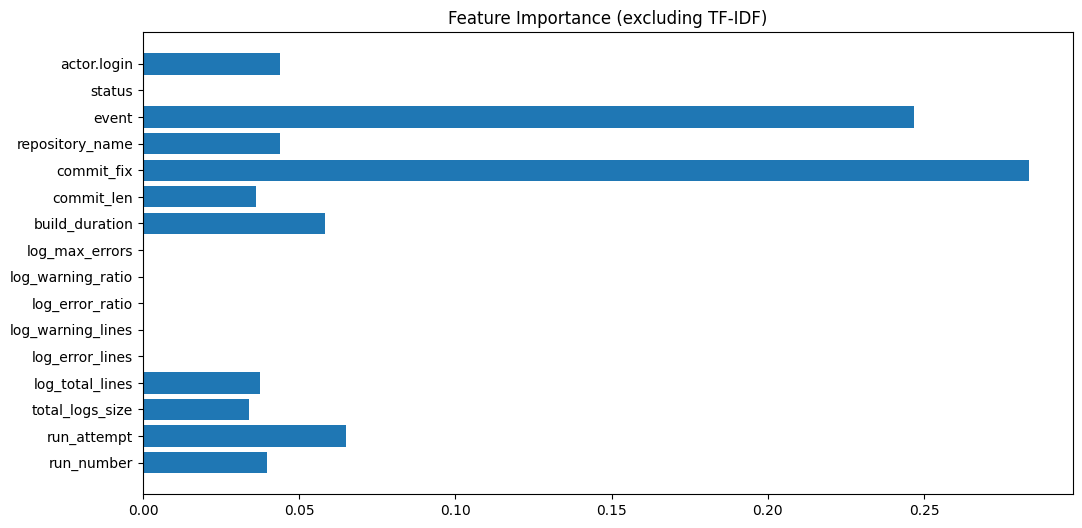

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import matplotlib.pyplot as plt

# Load dataset
file_path = "/content/drive/MyDrive/CICD/balanced_builds_10000_chunks.json"
df = pd.read_json(file_path, lines=True)

# Fill missing values in text columns
df = df.fillna("unknown")

# Feature engineering from logs
def extract_log_features(log_insights_list):
    if isinstance(log_insights_list, list):
        total_lines = sum(d.get('total_lines', 0) for d in log_insights_list)
        error_lines = sum(d.get('lines_with_errors', 0) for d in log_insights_list)
        warning_lines = sum(d.get('lines_with_warnings', 0) for d in log_insights_list)
        error_ratio = error_lines / total_lines if total_lines > 0 else 0
        warning_ratio = warning_lines / total_lines if total_lines > 0 else 0
        max_errors = max([d.get('lines_with_errors', 0) for d in log_insights_list], default=0)
        return pd.Series([total_lines, error_lines, warning_lines, error_ratio, warning_ratio, max_errors])
    else:
        return pd.Series([0, 0, 0, 0, 0, 0])

df[['log_total_lines', 'log_error_lines', 'log_warning_lines',
    'log_error_ratio', 'log_warning_ratio', 'log_max_errors']] = df['log_insights'].apply(extract_log_features)

# Build duration feature
df['build_duration'] = pd.to_datetime(df['updated_at'], errors='coerce').astype('int64') // 10**9 - \
                       pd.to_datetime(df['run_started_at'], errors='coerce').astype('int64') // 10**9

# Commit message features
df['commit_len'] = df['head_commit.message'].apply(lambda x: len(str(x)))
df['commit_fix'] = df['head_commit.message'].apply(lambda x: str(x).lower().count('fix'))

# Drop unused columns
df = df.drop(columns=['log_insights', 'head_commit.message',  'updated_at', 'run_started_at', 'created_at'])

# Encode categorical features
categorical_cols = ['repository_name', 'event', 'status', 'actor.login']
X_cat = df[categorical_cols].copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col].astype(str))

# Numeric features
numeric_cols = ['run_number', 'run_attempt', 'total_logs_size', 'log_total_lines',
                'log_error_lines', 'log_warning_lines', 'log_error_ratio', 'log_warning_ratio',
                'log_max_errors', 'build_duration', 'commit_len', 'commit_fix']
X_num = df[numeric_cols].copy()

# Convert numeric columns safely
X_num = X_num.apply(pd.to_numeric, errors='coerce').fillna(0)
X_num = X_num.astype(np.float64)
X_cat = X_cat.astype(np.float64)

# TF-IDF features from commit messages (can replace with actual commit messages)
tfidf = TfidfVectorizer(max_features=200)
X_tfidf = tfidf.fit_transform(df['commit_fix'].astype(str))  # simple placeholder; replace with head_commit.message text if needed

# Combine all features
X_combined = hstack([X_num.values, X_cat.values, X_tfidf])

# Encode target
y = LabelEncoder().fit_transform(df['conclusion'])

# Balance dataset using SMOTE
X_dense = np.asarray(X_combined.todense())
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_dense, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Hyperparameter tuning for XGBoost
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'gamma': [0, 1],
    'min_child_weight': [1, 3]
}

xgb = XGBClassifier(eval_metric='logloss', random_state=42, use_label_encoder=False)
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=10, cv=3,
                                   scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

# Predictions and evaluation
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Feature importance (numeric + categorical only; TF-IDF excluded)
importances = best_model.feature_importances_[:X_num.shape[1] + X_cat.shape[1]]
feature_names = numeric_cols + categorical_cols
plt.figure(figsize=(12,6))
plt.barh(feature_names, importances)
plt.title("Feature Importance (excluding TF-IDF)")
plt.show()


Accuracy: 0.9446484784889821

Confusion Matrix:
 [[3779  291]
 [ 131 3423]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95      4070
           1       0.92      0.96      0.94      3554

    accuracy                           0.94      7624
   macro avg       0.94      0.95      0.94      7624
weighted avg       0.95      0.94      0.94      7624



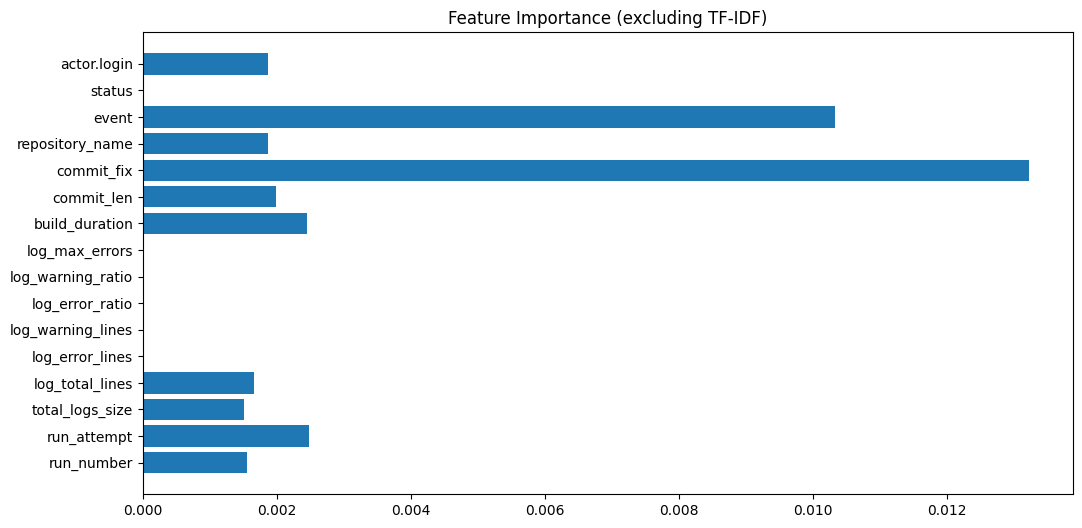

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN
from scipy.sparse import hstack
import matplotlib.pyplot as plt

# ---------------------------
# Load dataset
# ---------------------------
file_path = "/content/drive/MyDrive/CICD/balanced_builds_10000_chunks.json"
df = pd.read_json(file_path, lines=True)
df = df.fillna("unknown")

# ---------------------------
# Feature engineering from logs
# ---------------------------
def extract_log_features(log_insights_list):
    if isinstance(log_insights_list, list):
        total_lines = sum(d.get('total_lines', 0) for d in log_insights_list)
        error_lines = sum(d.get('lines_with_errors', 0) for d in log_insights_list)
        warning_lines = sum(d.get('lines_with_warnings', 0) for d in log_insights_list)
        error_ratio = error_lines / total_lines if total_lines > 0 else 0
        warning_ratio = warning_lines / total_lines if total_lines > 0 else 0
        max_errors = max([d.get('lines_with_errors', 0) for d in log_insights_list], default=0)
        return pd.Series([total_lines, error_lines, warning_lines, error_ratio, warning_ratio, max_errors])
    else:
        return pd.Series([0, 0, 0, 0, 0, 0])

df[['log_total_lines', 'log_error_lines', 'log_warning_lines',
    'log_error_ratio', 'log_warning_ratio', 'log_max_errors']] = df['log_insights'].apply(extract_log_features)

# Build duration feature
df['build_duration'] = pd.to_datetime(df['updated_at'], errors='coerce').astype('int64') // 10**9 - \
                       pd.to_datetime(df['run_started_at'], errors='coerce').astype('int64') // 10**9

# Commit message features
df['commit_len'] = df['head_commit.message'].apply(lambda x: len(str(x)))
df['commit_fix'] = df['head_commit.message'].apply(lambda x: str(x).lower().count('fix'))

# Drop unused columns
df = df.drop(columns=['log_insights', 'updated_at', 'run_started_at', 'created_at'])

# ---------------------------
# Encode categorical features
# ---------------------------
categorical_cols = ['repository_name', 'event', 'status', 'actor.login']
X_cat = df[categorical_cols].copy()
for col in categorical_cols:
    le = LabelEncoder()
    X_cat[col] = le.fit_transform(X_cat[col].astype(str))
X_cat = X_cat.astype(np.float64)

# ---------------------------
# Numeric features
# ---------------------------
numeric_cols = ['run_number', 'run_attempt', 'total_logs_size', 'log_total_lines',
                'log_error_lines', 'log_warning_lines', 'log_error_ratio', 'log_warning_ratio',
                'log_max_errors', 'build_duration', 'commit_len', 'commit_fix']
X_num = df[numeric_cols].copy()
X_num = X_num.apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float64)

# ---------------------------
# TF-IDF features (full commit messages)
# ---------------------------
tfidf = TfidfVectorizer(max_features=500)   # increase vocab size
X_tfidf = tfidf.fit_transform(df['head_commit.message'].astype(str))

# ---------------------------
# Combine all features
# ---------------------------
X_combined = hstack([X_num.values, X_cat.values, X_tfidf])

# ---------------------------
# Encode target
# ---------------------------
y = LabelEncoder().fit_transform(df['conclusion'])

# ---------------------------
# Balance dataset with SMOTEENN
# ---------------------------
X_dense = np.asarray(X_combined.todense())
smote_enn = SMOTEENN(random_state=42)
X_res, y_res = smote_enn.fit_resample(X_dense, y)

# ---------------------------
# Train/test split
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# ---------------------------
# Expanded hyperparameter grid
# ---------------------------
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1],
    'gamma': [0, 0.5, 1, 2],
    'min_child_weight': [1, 3, 5, 7]
}

xgb = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    reg_lambda=1,   # L2 regularization
    reg_alpha=0.5   # L1 regularization
)

random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_grid,
    n_iter=50,       # more iterations for better search
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# ---------------------------
# Train model
# ---------------------------
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

# ---------------------------
# Predictions and evaluation
# ---------------------------
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---------------------------
# Feature importance (numeric + categorical only; TF-IDF excluded)
# ---------------------------
importances = best_model.feature_importances_[:X_num.shape[1] + X_cat.shape[1]]
feature_names = numeric_cols + categorical_cols
plt.figure(figsize=(12,6))
plt.barh(feature_names, importances)
plt.title("Feature Importance (excluding TF-IDF)")
plt.show()


In [4]:
import joblib

joblib.dump(best_model, "/content/drive/MyDrive/CICD/xgb_cicd_model.pkl")
joblib.dump(tfidf, "/content/drive/MyDrive/CICD/tfidf_vectorizer.pkl")
print("✅ Model and vectorizer saved!")


✅ Model and vectorizer saved!


In [5]:
model = joblib.load("/content/drive/MyDrive/CICD/xgb_cicd_model.pkl")
tfidf = joblib.load("/content/drive/MyDrive/CICD/tfidf_vectorizer.pkl")


In [8]:
def predict_new_build(new_df):
    # same preprocessing as before
    new_df = new_df.fillna("unknown")
    new_df[['log_total_lines', 'log_error_lines', 'log_warning_lines',
            'log_error_ratio', 'log_warning_ratio', 'log_max_errors']] = \
            new_df['log_insights'].apply(extract_log_features)

    new_df['build_duration'] = pd.to_datetime(new_df['updated_at'], errors='coerce').astype('int64') // 10**9 - \
                               pd.to_datetime(new_df['run_started_at'], errors='coerce').astype('int64') // 10**9

    new_df['commit_len'] = new_df['head_commit.message'].apply(lambda x: len(str(x)))
    new_df['commit_fix'] = new_df['head_commit.message'].apply(lambda x: str(x).lower().count('fix'))

    X_num_new = new_df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(np.float64)
    X_cat_new = new_df[categorical_cols].copy()
    for col in categorical_cols:
        le = LabelEncoder()
        X_cat_new[col] = le.fit_transform(X_cat_new[col].astype(str))
    X_cat_new = X_cat_new.astype(np.float64)

    X_tfidf_new = tfidf.transform(new_df['head_commit.message'].astype(str))
    X_combined_new = hstack([X_num_new.values, X_cat_new.values, X_tfidf_new])
    X_dense_new = np.asarray(X_combined_new.todense())

    y_pred_new = model.predict(X_dense_new)
    return y_pred_new


In [10]:
import pandas as pd

new_build_df = pd.DataFrame([{
    "repository_name": "example/repo",
    "event": "push",
    "status": "completed",
    "actor.login": "devuser",
    "run_number": 101,
    "run_attempt": 1,
    "total_logs_size": 50000,
    "log_insights": [{"total_lines": 2000, "lines_with_errors": 15, "lines_with_warnings": 30}],
    "updated_at": "2025-10-16T15:00:00Z",
    "run_started_at": "2025-10-16T14:50:00Z",
    "created_at": "2025-10-16T14:45:00Z",
    "head_commit.message": "Fixed dependency issue in build process"
}])


In [11]:
# Extract log features
new_build_df[['log_total_lines', 'log_error_lines', 'log_warning_lines',
              'log_error_ratio', 'log_warning_ratio', 'log_max_errors']] = \
    new_build_df['log_insights'].apply(extract_log_features)

# Build duration
new_build_df['build_duration'] = pd.to_datetime(new_build_df['updated_at'], errors='coerce').astype('int64') // 10**9 - \
                                 pd.to_datetime(new_build_df['run_started_at'], errors='coerce').astype('int64') // 10**9

# Commit message features
new_build_df['commit_len'] = new_build_df['head_commit.message'].apply(lambda x: len(str(x)))
new_build_df['commit_fix'] = new_build_df['head_commit.message'].apply(lambda x: str(x).lower().count('fix'))

# Drop unused columns
new_build_df = new_build_df.drop(columns=['log_insights', 'updated_at', 'run_started_at', 'created_at'])

# Encode categorical
for col in categorical_cols:
    new_build_df[col] = new_build_df[col].astype(str).map(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )

# Numeric features
X_num_new = new_build_df[numeric_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float)

# TF-IDF
X_tfidf_new = tfidf.transform(new_build_df['head_commit.message'].astype(str))

# Combine all
from scipy.sparse import hstack
X_combined_new = hstack([X_num_new.values, new_build_df[categorical_cols].values, X_tfidf_new])


In [12]:
prediction = best_model.predict(X_combined_new)
print("Prediction:", "✅ Success" if prediction[0] == 1 else "❌ Failure")


Prediction: ✅ Success


In [13]:
import zipfile
import os

# Path to your dataset
file_path = "/content/drive/MyDrive/CICD/balanced_builds_10000_chunks.json"
zip_path = "/content/drive/MyDrive/CICD/balanced_builds_10000_chunks.zip"

# Create ZIP file
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(file_path, os.path.basename(file_path))

print(f"✅ JSON file compressed successfully to: {zip_path}")


✅ JSON file compressed successfully to: /content/drive/MyDrive/CICD/balanced_builds_10000_chunks.zip
